# HLA-ProtBERT Demo

This notebook demonstrates how to use the HLA-ProtBERT library to encode HLA alleles with pre-trained ProtBERT models.

## Overview

The HLA-ProtBERT library allows you to:
- Encode HLA alleles into high-dimensional protein embeddings
- Find similar alleles based on embedding similarity
- Compare different alleles
- Use these embeddings for downstream tasks like clinical prediction

## Setup

First, let's import the necessary libraries and set up the paths.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path to import modules
notebook_dir = Path().resolve()
project_dir = notebook_dir.parent
sys.path.insert(0, str(project_dir))

# Import our modules
from src.models.encoders.protbert import ProtBERTEncoder
from src.utils.logging import setup_logging

# Set up logging
logger = setup_logging(level="INFO")

# Set paths
data_dir = project_dir / "data"
sequence_file = data_dir / "processed" / "hla_sequences.pkl"
embeddings_dir = data_dir / "embeddings"

print(f"Project directory: {project_dir}")
print(f"Sequence file: {sequence_file}")
print(f"Embeddings directory: {embeddings_dir}")

py-ard not installed; allele resolution mapping will be limited


2025-06-03 10:29:18,061 - src.utils.logging - INFO - Logging initialized (level=INFO)


Project directory: /Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/hla-protbert
Sequence file: /Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/hla-protbert/data/processed/hla_sequences.pkl
Embeddings directory: /Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/hla-protbert/data/embeddings


## Initialize the ProtBERT Encoder

Now we'll initialize the ProtBERT encoder that will convert HLA allele sequences into embeddings.

In [2]:
# Initialize encoder
encoder = ProtBERTEncoder(
    sequence_file=sequence_file,
    cache_dir=embeddings_dir,
    pooling_strategy="mean",
    use_peptide_binding_region=True
)

print(f"ProtBERT model: {encoder.model_name}")
print(f"Pooling strategy: {encoder.pooling_strategy}")
print(f"Using peptide binding region: {encoder.use_peptide_binding_region}")
print(f"Device: {encoder.device}")

2025-06-03 10:29:18,080 - src.models.encoder - INFO - Loaded 26000 sequences from /Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/hla-protbert/data/processed/hla_sequences.pkl


2025-06-03 10:29:18,130 - src.models.encoder - INFO - Loaded 23492 cached embeddings from /Users/dakdemir/Library/CloudStorage/OneDrive-NMDP/Year2025/Github/hla-protbert/data/embeddings/hla_embeddings.pkl


2025-06-03 10:29:18,131 - src.models.encoders.protbert - INFO - Auto-detected device: cpu


2025-06-03 10:29:18,131 - src.models.encoders.protbert - INFO - Loading ProtBERT model: Rostlab/prot_bert


2025-06-03 10:29:18,796 - src.models.encoders.protbert - INFO - Successfully loaded model on cpu


ProtBERT model: Rostlab/prot_bert
Pooling strategy: mean
Using peptide binding region: True
Device: cpu


## Explore Available HLA Alleles

Let's see what HLA alleles are available in our dataset.

In [3]:
# Get allele counts by locus
alleles = list(encoder.sequences.keys())
print(f"Total number of alleles: {len(alleles)}")

# Count alleles per locus
locus_counts = {}
for allele in alleles:
    locus = allele.split('*')[0]
    locus_counts[locus] = locus_counts.get(locus, 0) + 1

# Display counts
for locus, count in sorted(locus_counts.items()):
    print(f"Locus {locus}: {count} alleles")

# Show a few example alleles for common loci
common_loci = ['A', 'B', 'C', 'DRB1']
for locus in common_loci:
    examples = [a for a in alleles if a.startswith(f"{locus}*")][:5]
    print(f"\nExample {locus} alleles: {', '.join(examples)}")

Total number of alleles: 26000
Locus A: 5489 alleles
Locus B: 6584 alleles
Locus C: 5206 alleles
Locus DMA: 9 alleles
Locus DMB: 9 alleles
Locus DOA: 17 alleles
Locus DOB: 20 alleles
Locus DPA1: 410 alleles
Locus DPB1: 1782 alleles
Locus DQA1: 474 alleles
Locus DQA2: 11 alleles
Locus DQB1: 1824 alleles
Locus DQB2: 10 alleles
Locus DRA: 18 alleles
Locus DRB1: 2607 alleles
Locus DRB3: 433 alleles
Locus DRB4: 194 alleles
Locus DRB5: 183 alleles
Locus E: 151 alleles
Locus F: 24 alleles
Locus G: 57 alleles
Locus HFE: 4 alleles
Locus MICA: 383 alleles
Locus MICB: 76 alleles
Locus TAP1: 12 alleles
Locus TAP2: 13 alleles

Example A alleles: A*01:01, A*01:02, A*01:03, A*01:04, A*01:06

Example B alleles: B*07:02, B*07:03, B*07:04, B*07:05, B*07:06

Example C alleles: C*01:02, C*01:03, C*01:04, C*01:05, C*01:06

Example DRB1 alleles: DRB1*01:01, DRB1*01:02, DRB1*01:03, DRB1*01:04, DRB1*01:05


## Encode Individual Alleles

Now let's encode some individual HLA alleles and examine their embeddings.

In [4]:
# Define some common alleles to encode
test_alleles = ["A*01:01", "A*02:01", "B*07:02", "B*08:01", "C*07:01"]

# Encode each allele
embeddings = {}
for allele in test_alleles:
    try:
        # Get protein sequence
        sequence = encoder.get_sequence(allele)
        if sequence is None:
            print(f"No sequence found for {allele}")
            continue
        
        # Get embedding
        embedding = encoder.get_embedding(allele)
        embeddings[allele] = embedding
        
        # Print info
        print(f"\n{allele}:")
        print(f"  Sequence: {sequence[:50]}..." if len(sequence) > 50 else f"  Sequence: {sequence}")
        print(f"  Sequence length: {len(sequence)} amino acids")
        print(f"  Embedding shape: {embedding.shape}")
        print(f"  Embedding stats: min={embedding.min():.4f}, max={embedding.max():.4f}, mean={embedding.mean():.4f}")
    except Exception as e:
        print(f"Error encoding {allele}: {e}")


A*01:01:
  Sequence: MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVG...
  Sequence length: 365 amino acids
  Embedding shape: (1024,)
  Embedding stats: min=-0.6218, max=2.0698, mean=0.0016

A*02:01:
  Sequence: MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVG...
  Sequence length: 365 amino acids
  Embedding shape: (1024,)
  Embedding stats: min=-0.6178, max=2.0492, mean=0.0017

B*07:02:
  Sequence: MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRFISVG...
  Sequence length: 362 amino acids
  Embedding shape: (1024,)
  Embedding stats: min=-0.5979, max=1.8506, mean=0.0016

B*08:01:
  Sequence: MLVMAPRTVLLLLSAALALTETWAGSHSMRYFDTAMSRPGRGEPRFISVG...
  Sequence length: 362 amino acids
  Embedding shape: (1024,)
  Embedding stats: min=-0.5440, max=1.8235, mean=0.0015

C*07:01:
  Sequence: MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRFISVG...
  Sequence length: 366 amino acids
  Embedding shape: (1024,)
  Embedding stats: min=-0.3895, max=1.3129, mean=0.0009


## Find Similar Alleles

One of the key features of HLA-ProtBERT is the ability to find similar alleles based on embedding similarity.

In [5]:
# Find similar alleles for each test allele
for allele in test_alleles:
    if allele not in embeddings:
        continue
        
    print(f"\nAlleles similar to {allele}:")
    similar = encoder.find_similar_alleles(allele, top_k=5)
    
    if not similar:
        print("  No similar alleles found")
        continue
        
    for similar_allele, similarity in similar:
        print(f"  {similar_allele}: similarity={similarity:.4f}")


Alleles similar to A*01:01:
  A*01:395: similarity=1.0000
  A*01:251: similarity=1.0000
  A*01:253: similarity=1.0000
  A*01:342: similarity=1.0000
  A*01:456: similarity=1.0000

Alleles similar to A*02:01:
  A*02:1120: similarity=1.0000
  A*02:1034: similarity=1.0000
  A*02:847: similarity=1.0000
  A*02:123: similarity=1.0000
  A*02:724: similarity=1.0000

Alleles similar to B*07:02:


  B*07:466: similarity=1.0000
  B*07:312: similarity=1.0000
  B*07:381: similarity=1.0000
  B*07:475: similarity=1.0000
  B*07:313: similarity=1.0000

Alleles similar to B*08:01:
  B*08:246: similarity=1.0000
  B*08:233: similarity=1.0000
  B*08:334: similarity=1.0000
  B*08:189: similarity=1.0000
  B*08:225: similarity=1.0000

Alleles similar to C*07:01:
  C*07:618: similarity=1.0000
  C*07:1168: similarity=1.0000
  C*07:1025: similarity=1.0000
  C*07:1060: similarity=1.0000
  C*07:1099: similarity=1.0000


## Compare Multiple Alleles

Let's compare the similarity between different alleles.

In [6]:
# Compare alleles
if len(embeddings) > 1:
    print("Pairwise similarities:")
    
    allele_list = list(embeddings.keys())
    for i, allele1 in enumerate(allele_list):
        for allele2 in allele_list[i+1:]:
            # Calculate cosine similarity
            similarity = encoder._cosine_similarity(embeddings[allele1], embeddings[allele2])
            print(f"  {allele1} vs {allele2}: {similarity:.4f}")
            
            # Interpret similarity
            if similarity > 0.99:
                print(f"    These alleles are identical or encode the same protein")
            elif similarity > 0.95:
                print(f"    These alleles are very similar (likely same protein group)")
            elif similarity > 0.90:
                print(f"    These alleles are functionally similar")
            elif similarity < 0.70:
                print(f"    These alleles are substantially different")

Pairwise similarities:
  A*01:01 vs A*02:01: 0.9954
    These alleles are identical or encode the same protein
  A*01:01 vs B*07:02: 0.9857
    These alleles are very similar (likely same protein group)
  A*01:01 vs B*08:01: 0.9749
    These alleles are very similar (likely same protein group)
  A*01:01 vs C*07:01: 0.7745
  A*02:01 vs B*07:02: 0.9825
    These alleles are very similar (likely same protein group)
  A*02:01 vs B*08:01: 0.9728
    These alleles are very similar (likely same protein group)
  A*02:01 vs C*07:01: 0.7735
  B*07:02 vs B*08:01: 0.9960
    These alleles are identical or encode the same protein
  B*07:02 vs C*07:01: 0.8360
  B*08:01 vs C*07:01: 0.8627


## Visualize Embeddings

Let's visualize the embeddings to get a better understanding of the relationships between alleles.

In [7]:
# Get embeddings for specific loci
loci_to_visualize = ['A', 'B', 'C']
loci_alleles = {}
loci_embeddings = {}

for locus in loci_to_visualize:
    # Get alleles for this locus
    locus_alleles = [a for a in alleles if a.startswith(f"{locus}*")][:20]  # Limit to 20 alleles per locus
    loci_alleles[locus] = locus_alleles
    
    # Get embeddings
    locus_embeddings = [encoder.get_embedding(a) for a in locus_alleles]
    loci_embeddings[locus] = np.array(locus_embeddings)
    
    print(f"Got embeddings for {len(locus_alleles)} {locus} alleles")

Got embeddings for 20 A alleles
Got embeddings for 20 B alleles
Got embeddings for 20 C alleles


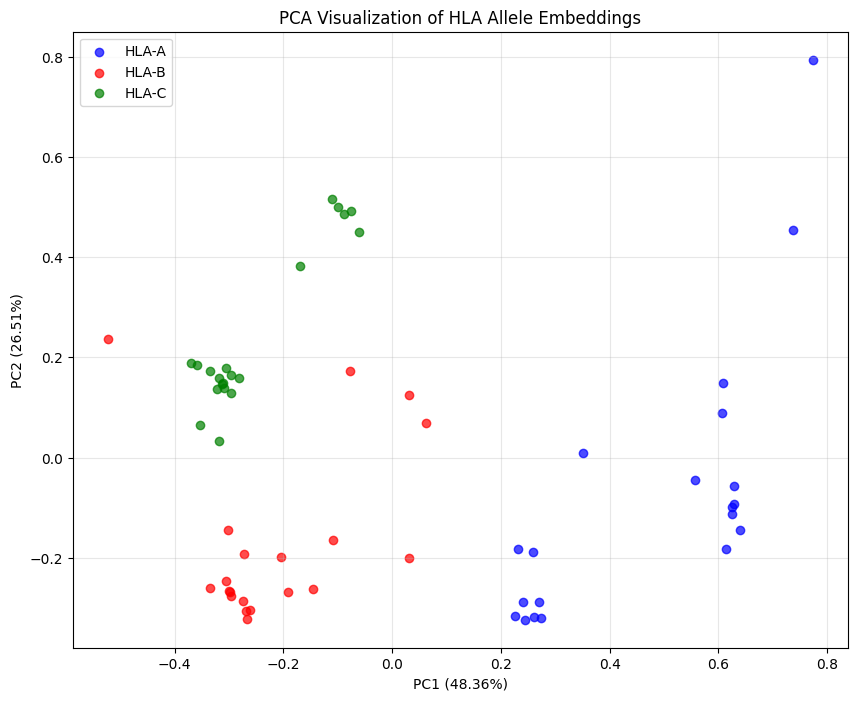

In [8]:
# Use PCA to reduce dimensions for visualization
from sklearn.decomposition import PCA

# Combine all embeddings
all_embeddings = np.vstack([loci_embeddings[locus] for locus in loci_to_visualize])
all_labels = []
for locus in loci_to_visualize:
    all_labels.extend([locus] * len(loci_alleles[locus]))

# Apply PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(10, 8))
colors = {'A': 'blue', 'B': 'red', 'C': 'green'}

for locus in loci_to_visualize:
    indices = [i for i, label in enumerate(all_labels) if label == locus]
    plt.scatter(
        reduced_embeddings[indices, 0], 
        reduced_embeddings[indices, 1],
        color=colors[locus],
        label=f"HLA-{locus}",
        alpha=0.7
    )

plt.title("PCA Visualization of HLA Allele Embeddings")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Heatmap of Similarity Between Common Alleles

Let's create a heatmap to visualize similarity between common alleles.

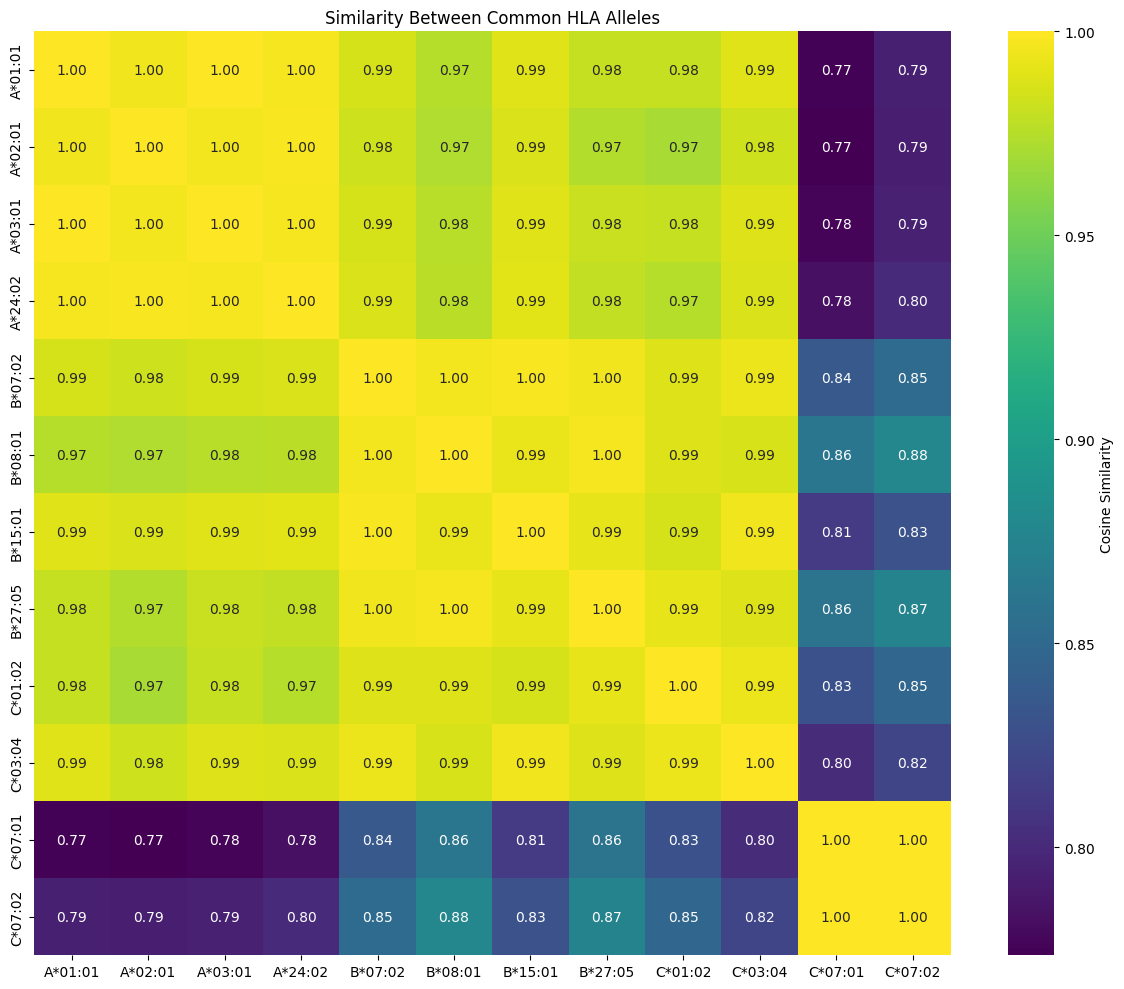

In [9]:
# Define common alleles for similarity matrix
common_alleles = [
    "A*01:01", "A*02:01", "A*03:01", "A*24:02",
    "B*07:02", "B*08:01", "B*15:01", "B*27:05",
    "C*01:02", "C*03:04", "C*07:01", "C*07:02"
]

# Calculate similarity matrix
similarity_matrix = np.zeros((len(common_alleles), len(common_alleles)))
valid_alleles = []

for i, allele1 in enumerate(common_alleles):
    try:
        embedding1 = encoder.get_embedding(allele1)
        valid_alleles.append(allele1)
        
        for j, allele2 in enumerate(common_alleles):
            if i == j:
                similarity_matrix[i, j] = 1.0  # Self-similarity
            elif j < i:
                similarity_matrix[i, j] = similarity_matrix[j, i]  # Symmetric
            else:
                try:
                    embedding2 = encoder.get_embedding(allele2)
                    similarity = encoder._cosine_similarity(embedding1, embedding2)
                    similarity_matrix[i, j] = similarity
                except Exception:
                    similarity_matrix[i, j] = np.nan
    except Exception:
        # Skip alleles that can't be encoded
        print(f"Skipping {allele1} - could not get embedding")
        continue

# Plot heatmap
if valid_alleles:  # Only plot if we have valid alleles
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        similarity_matrix[:len(valid_alleles), :len(valid_alleles)],
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=valid_alleles,
        yticklabels=valid_alleles,
        cbar_kws={"label": "Cosine Similarity"}
    )
    plt.title("Similarity Between Common HLA Alleles")
    plt.tight_layout()
    plt.show()

## Practical Use Case: Donor-Recipient Matching

Let's demonstrate a practical use case of HLA-ProtBERT for donor-recipient matching in transplantation.

In [10]:
# Define donor and recipient HLA types
donor = {
    "A": ["A*01:01", "A*02:01"],
    "B": ["B*07:02", "B*08:01"],
    "C": ["C*07:01", "C*07:02"]
}

recipient = {
    "A": ["A*01:01", "A*24:02"],
    "B": ["B*07:02", "B*15:01"],
    "C": ["C*03:04", "C*07:01"]
}

# Function to calculate match score
def calculate_match_score(donor, recipient, encoder):
    match_scores = {}
    overall_match = 0.0
    count = 0
    
    for locus in donor.keys():
        locus_scores = []
        
        for d_allele in donor[locus]:
            for r_allele in recipient[locus]:
                try:
                    # Get embeddings
                    d_embedding = encoder.get_embedding(d_allele)
                    r_embedding = encoder.get_embedding(r_allele)
                    
                    # Calculate similarity
                    similarity = encoder._cosine_similarity(d_embedding, r_embedding)
                    locus_scores.append((d_allele, r_allele, similarity))
                    
                    overall_match += similarity
                    count += 1
                except Exception as e:
                    print(f"Error comparing {d_allele} and {r_allele}: {e}")
        
        match_scores[locus] = locus_scores
    
    # Calculate average match score
    avg_match = overall_match / count if count > 0 else 0.0
    
    return match_scores, avg_match

# Calculate match score
match_scores, avg_match = calculate_match_score(donor, recipient, encoder)

# Print results
print(f"Donor-Recipient HLA Match Analysis")
print(f"Overall Match Score: {avg_match:.4f}\n")

for locus, scores in match_scores.items():
    print(f"HLA-{locus} Matching:")
    for d_allele, r_allele, similarity in scores:
        match_quality = "Exact match" if similarity > 0.99 else \
                       "Very close match" if similarity > 0.95 else \
                       "Functional match" if similarity > 0.90 else \
                       "Partial match" if similarity > 0.80 else \
                       "Mismatch"
        print(f"  {d_allele} vs {r_allele}: {similarity:.4f} ({match_quality})")
    print()

Donor-Recipient HLA Match Analysis
Overall Match Score: 0.9664

HLA-A Matching:
  A*01:01 vs A*01:01: 1.0000 (Exact match)
  A*01:01 vs A*24:02: 0.9966 (Exact match)
  A*02:01 vs A*01:01: 0.9954 (Exact match)
  A*02:01 vs A*24:02: 0.9982 (Exact match)

HLA-B Matching:
  B*07:02 vs B*07:02: 1.0000 (Exact match)
  B*07:02 vs B*15:01: 0.9981 (Exact match)
  B*08:01 vs B*07:02: 0.9960 (Exact match)
  B*08:01 vs B*15:01: 0.9928 (Exact match)

HLA-C Matching:
  C*07:01 vs C*03:04: 0.8010 (Partial match)
  C*07:01 vs C*07:01: 1.0000 (Exact match)
  C*07:02 vs C*03:04: 0.8196 (Partial match)
  C*07:02 vs C*07:01: 0.9991 (Exact match)



## Conclusion

In this notebook, we've demonstrated how to use the HLA-ProtBERT library to:

1. Encode HLA alleles into high-dimensional protein embeddings
2. Find similar alleles based on embedding similarity
3. Compare multiple alleles
4. Visualize embeddings using dimensionality reduction
5. Perform donor-recipient matching analysis

These embeddings can be used for various downstream tasks such as:
- Clinical outcome prediction
- Donor-recipient matching optimization
- Studying HLA structure-function relationships
- Understanding HLA compatibility beyond traditional matching criteria